<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#単一財の市場モデルをPythonで実装する" data-toc-modified-id="単一財の市場モデルをPythonで実装する-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>単一財の市場モデルをPythonで実装する</a></span></li></ul></div>

# 単一財の市場モデルをPythonで実装する

Market class を実装する

Market class は需要曲線、供給曲線を持ち、個々の消費者のwtpをp, Qを生産量、tを財一単位当たりの税とする。
    需要曲線の切片(intercept_d)を$a_d$,係数(coefficient_d)を$b_d$として

需要曲線:$ Q = a_d - b_dp $

供給曲線の切片(intercept_s)を$a_s$,係数(coefficient_s)を$b_s$として

供給曲線:$Q= a_s + b_sp$

と置く

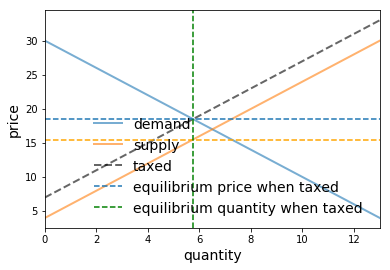

In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

class Market:
    
    def __init__(self,intercept_d,coefficient_d,intercept_s,coefficient_s):
        self.intercept_d= intercept_d
        self.intercept_s= intercept_s
        self.coefficient_d= coefficient_d
        self.coefficient_s=coefficient_s
        self.tax_price=0
        if intercept_d < intercept_s:
            raise ValueError("insufficient Demand Error")
    
    def equilibrium_price(self):
        return (self.intercept_d - self.intercept_s + self.coefficient_s*self.tax_price)/(self.coefficient_d+self.coefficient_s)
    
    def be_taxed_at_the_rate_of(self,t,on="producer"):
        
        if on=="producer":
            self.tax_price= t
        else:
            raise ValueError("innapropriate argument ")
    
    def equilibrium_quantity(self):
        return self.intercept_d - self.coefficient_d*self.equilibrium_price()
    
    def inverse_demand(self,x):
        return self.intercept_d/self.coefficient_d -(1/self.coefficient_d)*x
    
    def inverse_supply(self,x):
        return -(self.intercept_s/self.coefficient_s) + (1/self.coefficient_s)*x + self.tax_price
    
m = Market(15,0.5,-2,0.5)
m.equilibrium_price(),m.equilibrium_quantity()
#m.be_taxed_at_the_rate_of(3,on="producer")
m.equilibrium_price(),m.equilibrium_quantity()
q_max= m.equilibrium_quantity()*2
q_grid=np.linspace(0.0,q_max,100)
pd = m.inverse_demand(q_grid)
ps = m.inverse_supply(q_grid)
m2=Market(15,0.5,-2,0.5)
m2.be_taxed_at_the_rate_of(3,on='producer')

ps_with_tax= m2.inverse_supply(q_grid)
fig,ax= plt.subplots()
ax.plot(q_grid, pd, lw=2, alpha=0.6, label='demand')
ax.plot(q_grid, ps, lw=2, alpha=0.6, label='supply')
ax.plot(q_grid,ps_with_tax,'--k',lw=2,alpha=0.6,label="taxed")
ax.set_xlabel('quantity', fontsize=14)
ax.set_xlim(0, q_max)
ax.set_ylabel('price', fontsize=14)
ax.axhline(m.inverse_supply(m2.equilibrium_quantity()),ls='--',c='orange')
ax.axhline(m2.equilibrium_price(),ls='--',label='equilibrium price when taxed')
ax.axvline(m2.equilibrium_quantity(),ls='--',c='green',label='equilibrium quantity when taxed ')
ax.legend(loc='lower right', frameon=False, fontsize=14)
plt.show()

In [2]:
import numpy as np
from numba import jit
import quantecon as qe
from quantecon.distributions import BetaBinomial

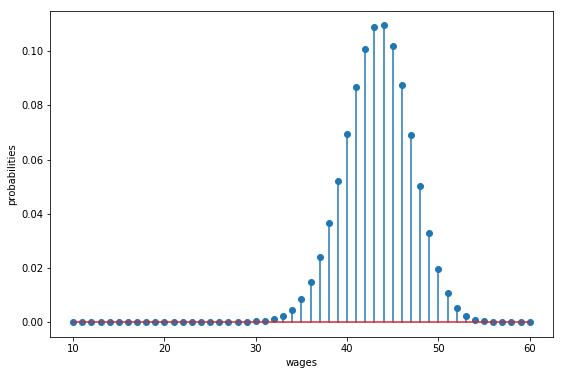

In [3]:
n,a,b= 50,200,100
w_min,w_max=10,60
w_vals = np.linspace(w_min,w_max,n+1)
w_vals
# n: 区切り,a: parameter 1, b: parameter 2
dist= BetaBinomial(n,a,b)
phi_vals= dist.pdf()
fig,ax= plt.subplots(figsize=(9,6))
ax.stem(w_vals,phi_vals,label='$\phi (w\')$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')
plt.show()

不動点定理を応用したアルゴリズムで$v'$について近似解を得る。

アルゴリズムは次の５ステップから成る。

1. 適当な初期値$v$を選ぶ
2. 新しいv'を$v'_i=max\{ \frac{w_i}{1-\beta}, c + \beta \sum_j v_j \phi(w_j) \}, i = 1,...,n$より計算する
3. $v$と$v'$の偏差を計算する
4. 偏差が良き血を越えた場合、$v=v'$とし、２に戻る。それ以外の場合は5に進む
5. vを返す


In [4]:
def plot_value_function_seq(ax,
c=25,
β=0.99,
w_vals=w_vals,
phi_vals=phi_vals,
num_plots=6):
    v = w_vals / (1 - β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(w_vals, v, label=f"iterate {i}")
        # Update guess
        for j, w in enumerate(w_vals):
            stop_val = w / (1 - β)
            cont_val = c + β * np.sum(v * phi_vals)
            v_next[j] = max(stop_val, cont_val)
            v[:] = v_next
    ax.legend(loc='lower right')

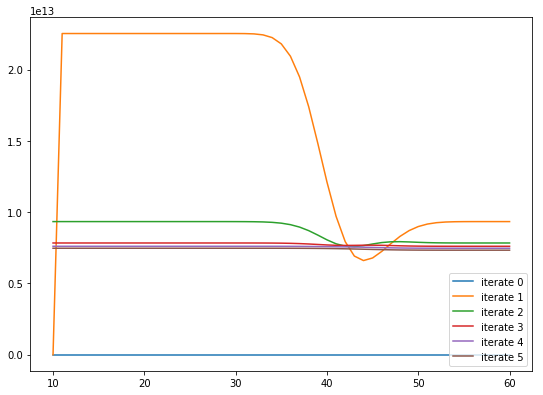

In [5]:
fig, ax = plt.subplots(figsize=(9, 6.5))
plot_value_function_seq(ax)
plt.show()

In [6]:
@jit(nopython=True)
def compute_reservation_wage(c=25,
                             beta=0.99,
                             w_vals=w_vals,
                             phi_vals=phi_vals,
                             max_iter=500,
                             tol=1e-6):
    v = w_vals / (1 - beta)
    v_next = np.empty_like(v)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:
        for j, w in enumerate(w_vals):
            stop_val = w / (1 - beta)
            cont_val = c + beta * np.sum(v * phi_vals)
            v_next[j] = max(stop_val, cont_val)
        error = np.max(np.abs(v_next - v))
        i += 1
        v[:] = v_next
        return (1 - beta) * (c + beta * np.sum(v * phi_vals))


In [7]:
compute_reservation_wage()

44.48312375644215

In [8]:
from random import uniform, seed
from math import sqrt

Entering loop  1


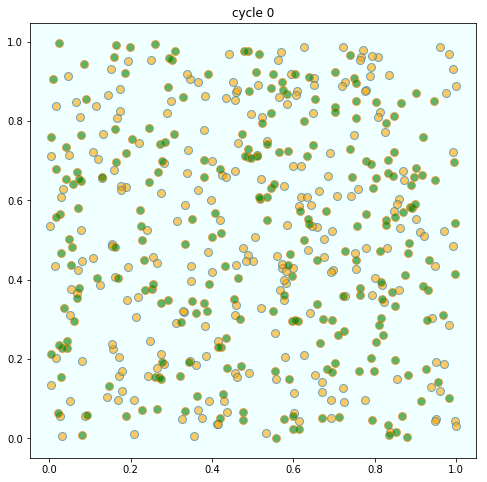

Entering loop  2


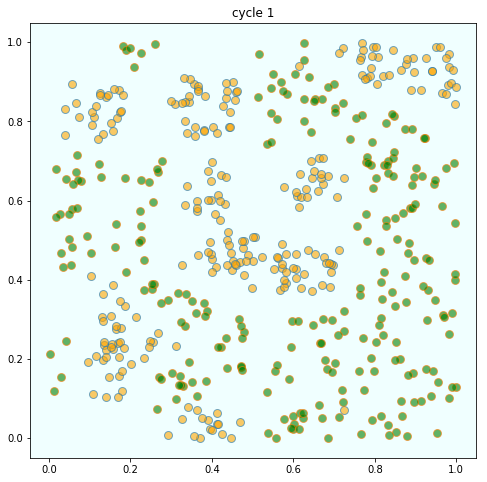

Entering loop  3


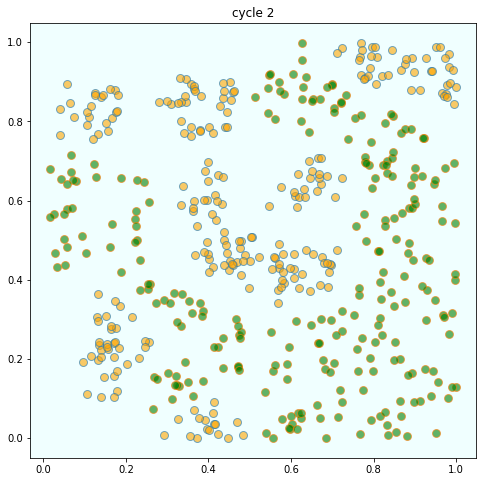

Converged, terminating.


In [9]:
seed(10)

class Agent:
    def __init__(self,type):
        self.type=type
        self.draw_location()
    
    def draw_location(self):
        self.location= uniform(0,1),uniform(0,1)
        
    def get_distance(self,other):
        a = (self.location[0]-other.location[0])**2
        b = (self.location[1]-other.location[1])**2
        return sqrt(a+b)
    def is_happy(self,agents):
        distances=[]
        for agent in agents:
            if self != agent:
                distance = self.get_distance(agent)
                distances.append((distance,agent))
        distances.sort()
        neighbors=[agent for d, agent in distances[:num_neighbors]]
        num_same_type = sum(self.type == agent.type for agent in neighbors)
        return num_same_type >= require_same_type
    def update(self,agents):
        while not self.is_happy(agents):
            self.draw_location()
def plot_distribution(agents,cycle_num):
    x_values_0,y_values_0=[],[]
    x_values_1,y_values_1=[],[]
    for agent in agents:
        x,y= agent.location
        if agent.type==0:
            x_values_0.append(x)
            y_values_0.append(y)
        else:
            x_values_1.append(x)
            y_values_1.append(y)
        
    fig,ax = plt.subplots(figsize=(8,8))
    plot_args={"markersize":8,"alpha":0.6}
    ax.set_facecolor("azure")
    ax.plot(x_values_0,y_values_0,'o',markerfacecolor="orange",**plot_args)
    ax.plot(x_values_1,y_values_1,'o',markerfacecolor="green",**plot_args)
    ax.set_title(f'cycle {cycle_num - 1}')
    plt.show()

num_of_type_0 = 250
num_of_type_1 = 250
num_neighbors = 10      # Number of agents regarded as neighbors
require_same_type = 7   # Want at least this many neighbors to be same type

# == Create a list of agents == #
agents = [Agent(0) for i in range(num_of_type_0)]
agents.extend(Agent(1) for i in range(num_of_type_1))
count = 1
# ==  Loop until none wishes to move == #
while True:
    print('Entering loop ', count)
    plot_distribution(agents, count)
    count += 1
    no_one_moved = True
    for agent in agents:
        old_location = agent.location
        agent.update(agents)
        if agent.location != old_location:
            no_one_moved = False
    if no_one_moved:
        break

print('Converged, terminating.')

    




In [56]:
class Boid:
    def __init__(self):
        self.set_direction(np.array([uniform(-5,5),uniform(-5,5)]))
        self.set_location()
        
    def set_location(self):
        self.location = np.array([uniform(0,300),uniform(0,300)])
    
    def set_direction(self,direction):
        self.direction = direction
    
    def avoid(self, boids):
        avoid_directions=[np.array([0,0])]
        for boid in boids:
            if self != boid:
                if self.get_distance_from(boid) <= collision_avoidance_distance:
                    avoid_directions.append(
                        np.array([
                            self.location[0] - boid.location[0],
                            self.location[1] - boid.location[1]
                        ])
                    )
                    
        self.set_direction(sum(avoid_directions)*0.8)
        self.location+=self.direction

    def  follow(self,boids):
        the_other_boids = [boid for boid in boids if boid != self]
        vecs_of_the_other_boids = [
            np.array([boid.direction[0],boid.direction[1]]) for boid in the_other_boids
        ]
        
        average_vec_except_self = sum(vecs_of_the_other_boids)/len(vecs_of_the_other_boids)
        self.set_direction((average_vec_except_self - self.direction)*0.8)
        self.location += self.direction
    
    def converge(self,boids):
        the_other_boids = [boid for boid in boids if boid != self]
        locs_of_the_other_boids =[
            np.array([boid.location[0],boid.location[1]]) for boid in boids
        ]
        center_of_the_others = sum(locs_of_the_other_boids)/len(locs_of_the_other_boids)
        direction = center_of_the_others - self.location
        self.set_direction(direction*0.7)
        self.location += self.direction
        
        
        
    
    def get_distance_from(self,another_boid):
        a = (self.location[0]-another_boid.location[0])**2
        b = (self.location[1]-another_boid.location[1])**2
        return sqrt(a+b)


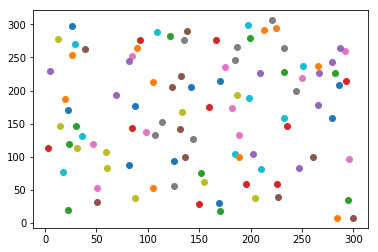

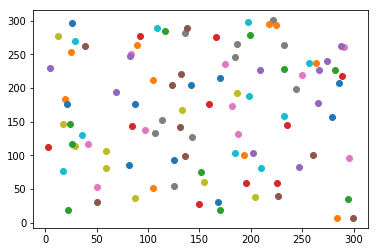

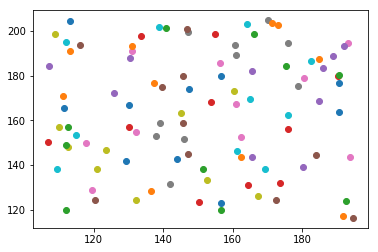

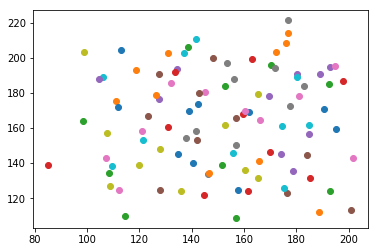

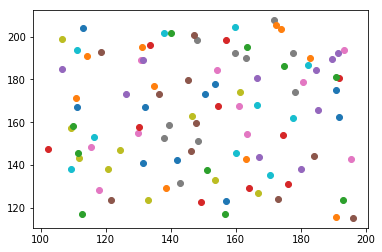

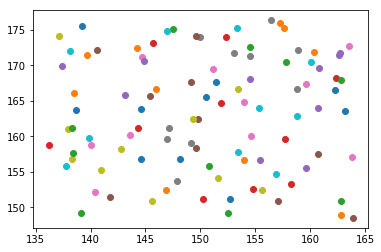

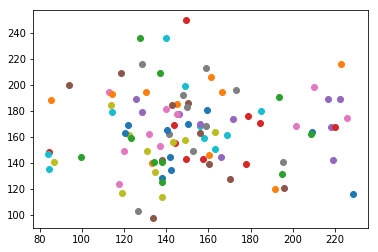

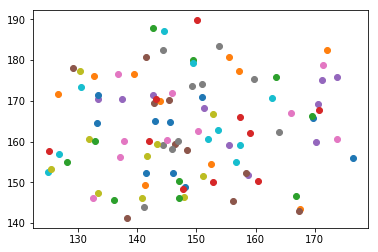

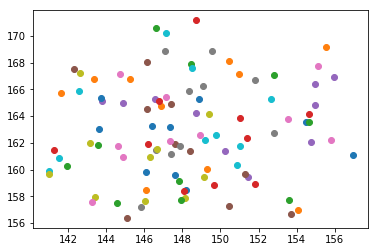

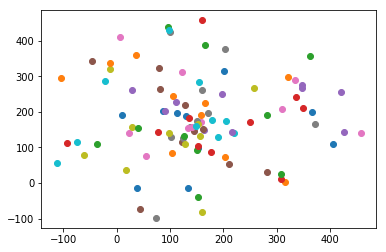

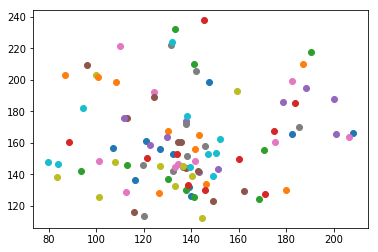

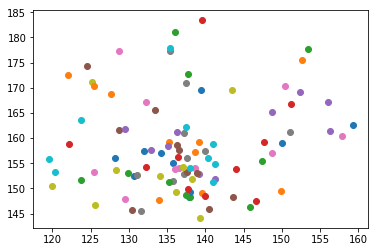

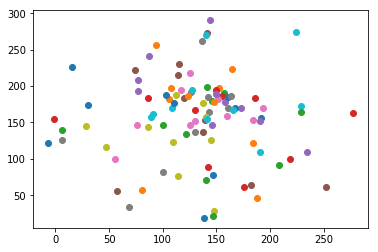

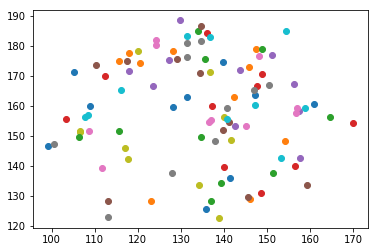

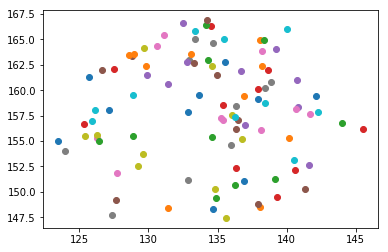

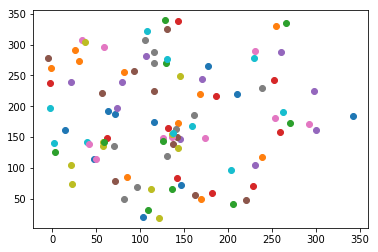

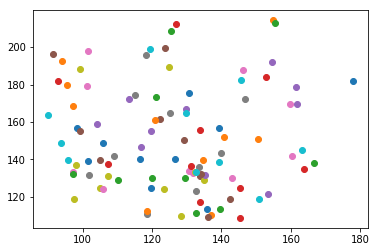

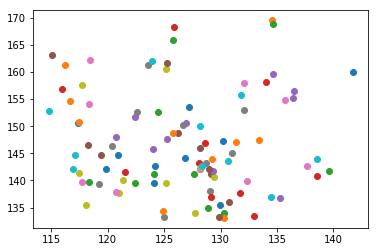

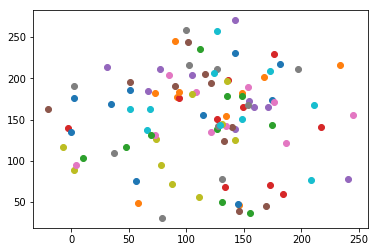

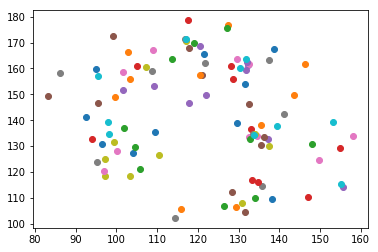

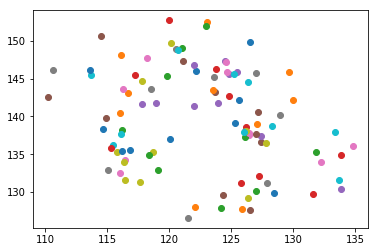

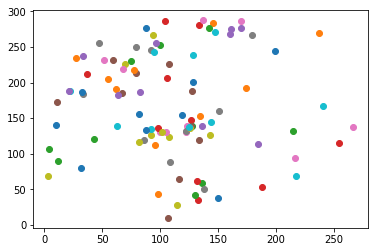

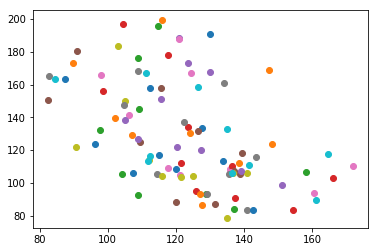

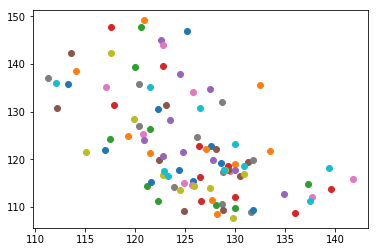

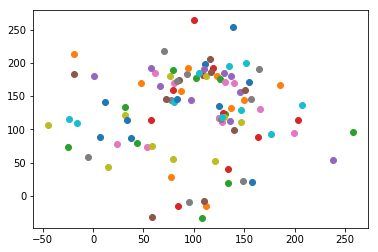

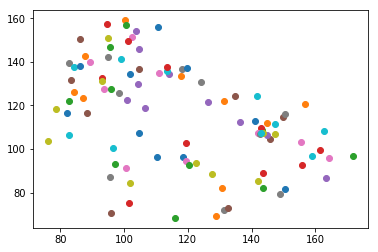

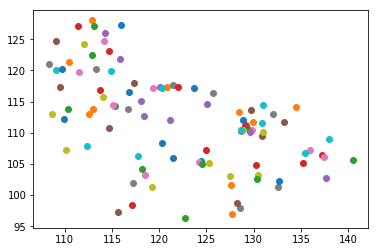

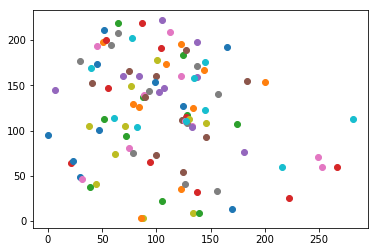

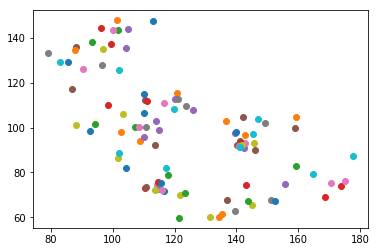

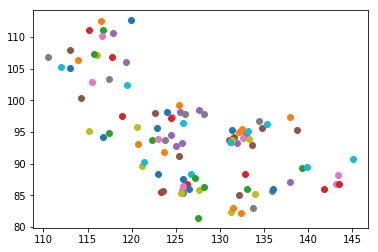

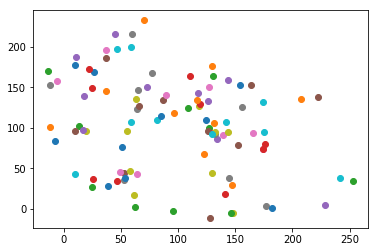

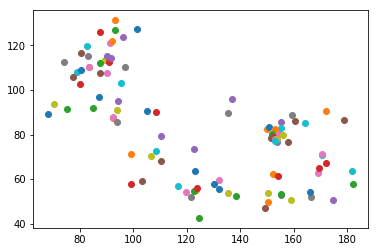

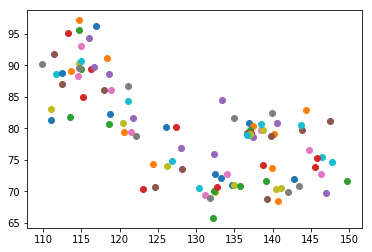

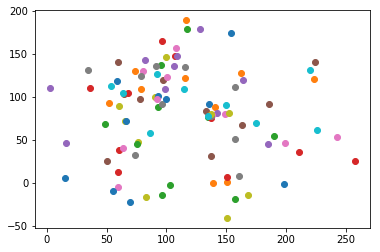

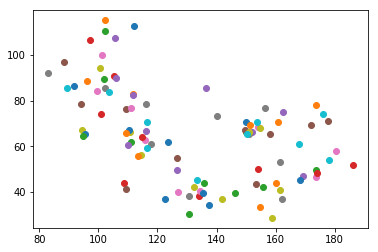

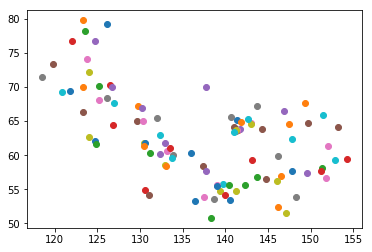

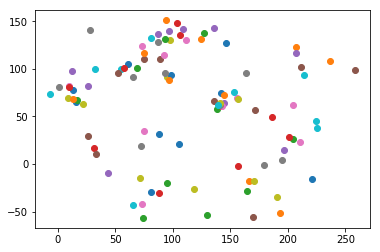

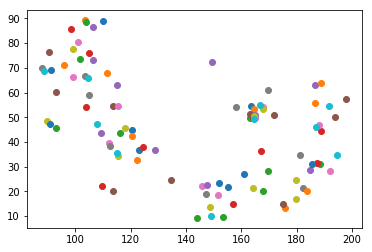

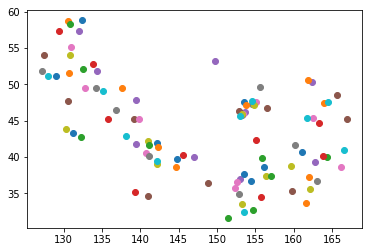

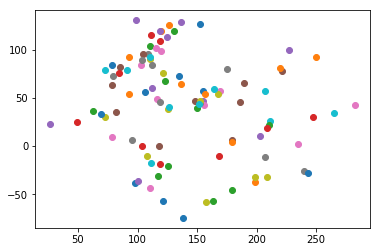

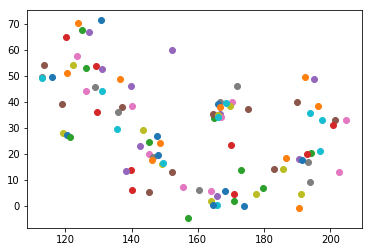

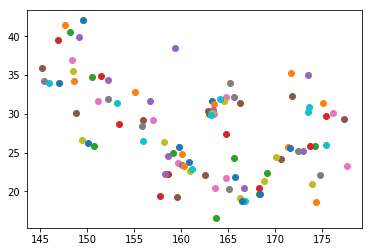

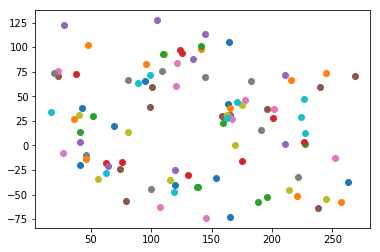

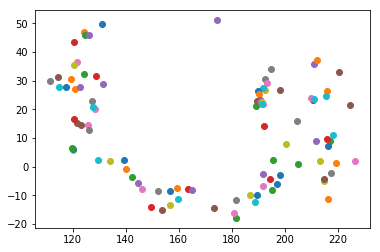

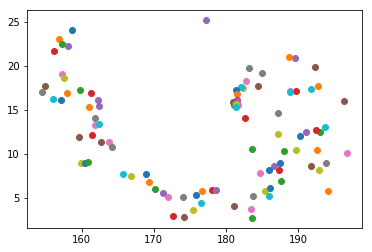

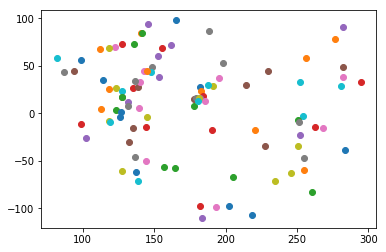

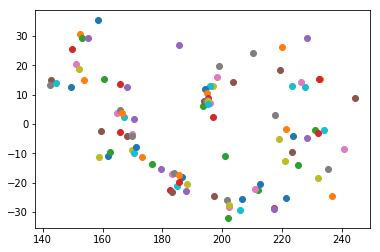

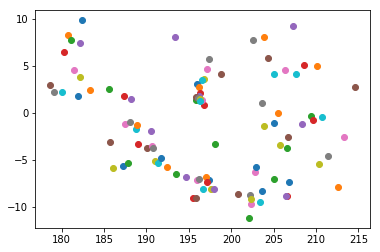

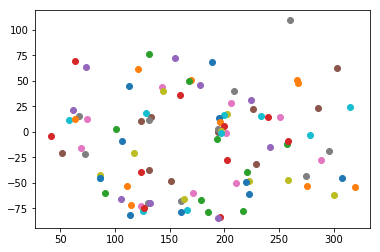

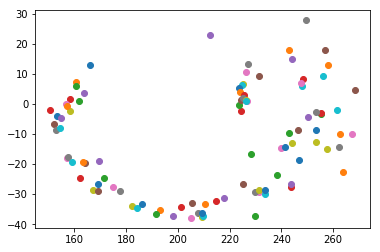

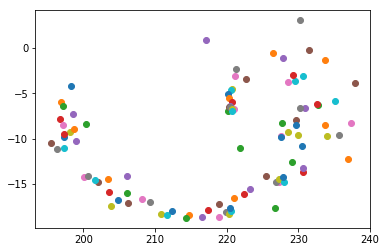

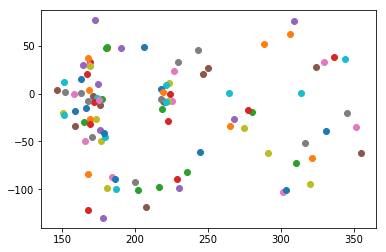

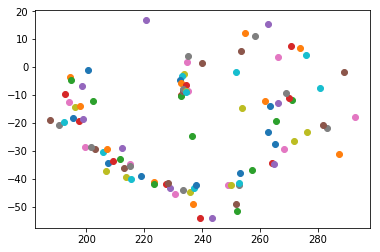

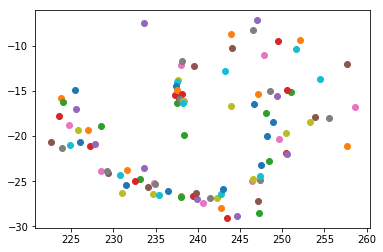

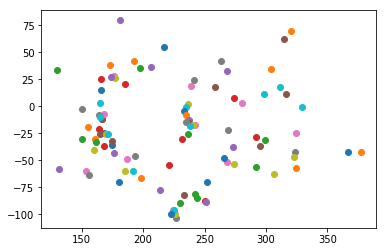

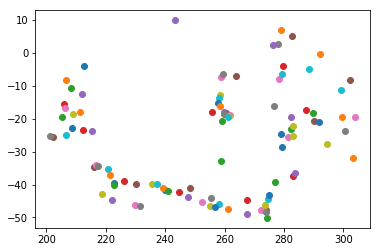

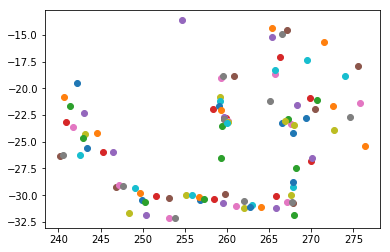

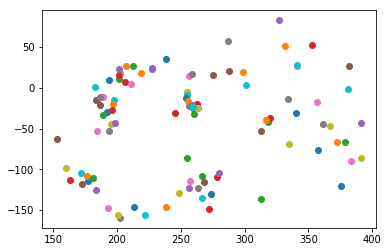

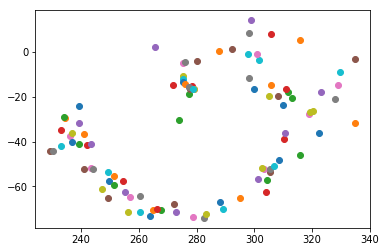

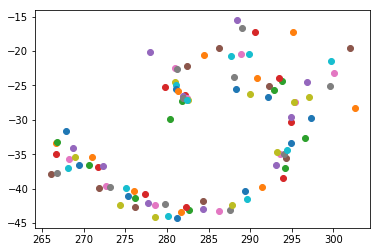

In [57]:
collision_avoidance_distance=10
boids = [Boid() for i in range(100)]
fig=plt.figure()
ims=[]
for i in range(20):
    
    for boid in boids:
        boid.avoid(boids)
        im=plt.plot(boid.location[0],boid.location[1],'o')
        ims.append([im])
    plt.show()
    
    for boid in boids:
        boid.follow(boids)
        im=plt.plot(boid.location[0],boid.location[1],'o')
        ims.append([im])
    plt.show()

    for boid in boids:
        boid.converge(boids)
        im=plt.plot(boid.location[0],boid.location[1],'o')
        ims.append([im])
    plt.show()


In [ ]:
np.array([1,2])[1]

In [ ]:
hoge=[]
hoge.append(np.array([0,0]))
hoge.append(np.array([0,0]))
hoge
sum(np.array([1,1]))

In [ ]:
sum(hoge)